# Working with Raster Data

This is a very brief introduction to reading raster data and basic manipulations in Python. We'll walk through one of the most commonly used raster python packages, `rasterio`. We'll be using the [National Land Cover Database (NLCD)](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend).

<img src="https://www.mdpi.com/remotesensing/remotesensing-11-02971/article_deploy/html/images/remotesensing-11-02971-g004.png" width="600">

> Note: They also have a [cool online viewer](https://www.mrlc.gov/viewer/) that is free and open access.

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib
from matplotlib.patches import Patch

import json
import numpy as np

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

To use raster data we'll be using the `rasterio` package, which is a popular package that helps you read, write, and manipulate raster data.

In [6]:
import rasterio
from rasterio.plot import show, plotting_extent

## 16.1 Import data and plot

To open our NLCD subset data, we'll use the `rasterio.open` function

In [7]:
fulton_nlcd_2023 = rasterio.open('data/fulton_nlcd_2023.tiff')

Let's check out what we get.

In [8]:
fulton_nlcd_2023

<open DatasetReader name='data/fulton_nlcd_2023.tiff' mode='r'>

Let's dissect this output here. We can look at the helper documentation for clues.

In [9]:
?rasterio.open

Signature:
rasterio.open(
    fp,
    mode='r',
    driver=None,
    width=None,
    height=None,
    count=None,
    crs=None,
    transform=None,
    dtype=None,
    nodata=None,
    sharing=False,
    opener=None,
    **kwargs,
)
Docstring:
Open a dataset for reading or writing.

The dataset may be located in a local file, in a resource located by
a URL, or contained within a stream of bytes. This function accepts
different types of fp parameters. However, it is almost always best
to pass a string that has a dataset name as its value. These are
passed directly to GDAL protocol and format handlers. A path to
a zipfile is more efficiently used by GDAL than a Python ZipFile
object, for example.

In read ('r') or read/write ('r+') mode, no keyword arguments are
required: these attributes are supplied by the opened dataset.

In write ('w' or 'w+') mode, the driver, width, height, count, and
dtype keywords are strictly required.

Parameters
----------
fp : str, os.PathLike, file-like, or 

Which reads that the function returns a ``DatasetReader`` or ``DatasetWriter`` object. Unlike in `GeoPandas` which we've been utilizing a lot of, we don't have a directly editable object here. However, `rasterio` does have functions in place where we can still use this returned object directly.

For example, we can easily plot our NLCD data using `rasterio.plot.show`.

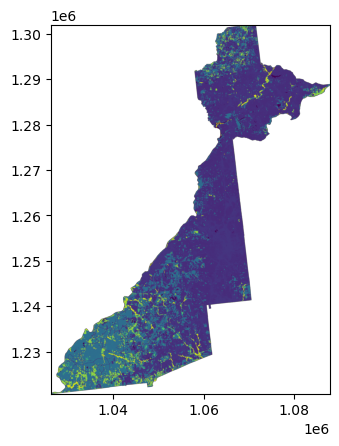

<Axes: >

In [10]:
rasterio.plot.show(fulton_nlcd_2023)

And just like how we formatted our `matplotlib` plots when we were using GeoDataFrames, we can still do that with this raster plotting function.

In [11]:
?rasterio.plot.show

Signature:
rasterio.plot.show(
    source,
    with_bounds=True,
    contour=False,
    contour_label_kws=None,
    ax=None,
    title=None,
    transform=None,
    adjust=False,
    **kwargs,
)
Docstring:
Display a raster or raster band using matplotlib.

Parameters
----------
source : array or dataset object opened in 'r' mode or Band or tuple(dataset, bidx)
    If Band or tuple (dataset, bidx), display the selected band.
    If raster dataset display the rgb image
    as defined in the colorinterp metadata, or default to first band.
with_bounds : bool (opt)
    Whether to change the image extent to the spatial bounds of the image,
    rather than pixel coordinates. Only works when source is
    (raster dataset, bidx) or raster dataset.
contour : bool (opt)
    Whether to plot the raster data as contours
contour_label_kws : dictionary (opt)
    Keyword arguments for labeling the contours,
    empty dictionary for no labels.
ax : matplotlib.axes.Axes, optional
    Axes to plot on, oth

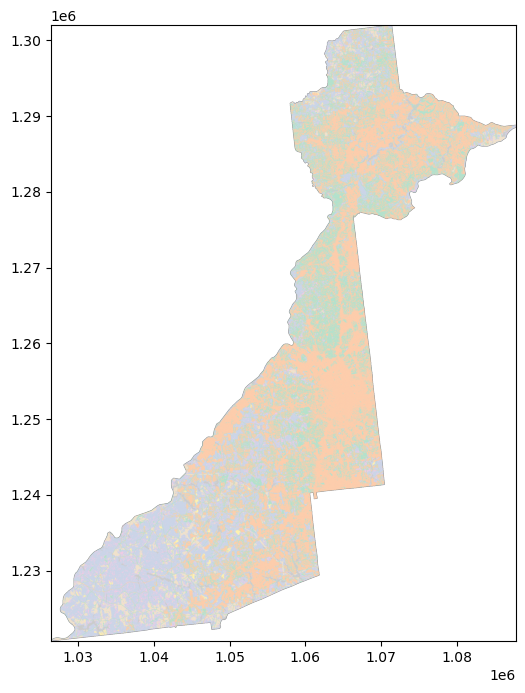

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
plt_nlcd = rasterio.plot.show(fulton_nlcd_2023, cmap='Pastel2', ax=ax)

(Take note of what you think could be improved here... we'll come back to this)

We can also plot a histogram of our data in a very similar way.

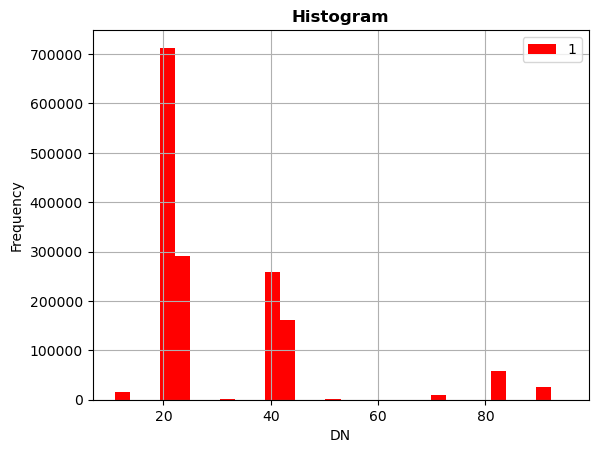

In [13]:
rasterio.plot.show_hist(fulton_nlcd_2023, bins=30)

We can see that we have more values on the lower end than on the higher end. To really understand the values that we see here let's [take a look at the legend](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend).

## Raster data structure

Now that we have a basic grasp on how to pull in and plot raster data, we can dig a little deeper to see what information we have.

First let's check the number of bands there are in our dataset.

In [14]:
fulton_nlcd_2023.count

1

In this case we only have 1 band. If you're pulling in aerial image, you might have 3 bands (red, green, blue). In the case you're bringing in remote sensing data like Landsat or MODIS you might have more!

Not let's check out what meta data we have.

In [15]:
fulton_nlcd_2023.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 250.0,
 'width': 2047,
 'height': 2711,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, 1026375.0,
        0.0, -30.0, 1302015.0)}

So we have a lot of good information here. Let's unpack it:

- `driver`: the file type (simialr to what we see in `open` and Geopandas `open`)
- `dtype`: the data type of each of your pixels
- `nodata`: the value that is set for no data pixels
- `width`: the number of pixels wide your dataset is
- `height`: the number of pixels high your dataset is
- `count`: the number of bands in your dataset
- `crs`: the coordiante reference system (CRS) of your data
- `transform`: the affine transform matrix that tell us which pixel locations in each row and column align with spatial locations (longitude, latitude).

We can also get similar information by calling `profile`.

In [16]:
fulton_nlcd_2023.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 250.0, 'width': 2047, 'height': 2711, 'count': 1, 'crs': CRS.from_wkt('PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 1026375.0,
       0.0, -30.0, 1302015.0), 'blockxsize': 2047, 'blockysize': 4, 'tiled': False, 'interleave': 'band'}

In [17]:
fulton_nlcd_2023.crs

CRS.from_wkt('PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Okay, but now we want to actually access our data. We can read in our data as a Numpy ndarray.

In [18]:
nlcd_2023_array = fulton_nlcd_2023.read()
nlcd_2023_array

array([[[250, 250, 250, ..., 250, 250, 250],
        [250, 250, 250, ..., 250, 250, 250],
        [250, 250, 250, ..., 250, 250, 250],
        ...,
        [250,  11,  41, ..., 250, 250, 250],
        [250,  71,  81, ..., 250, 250, 250],
        [ 11,  81,  81, ..., 250, 250, 250]]],
      shape=(1, 2711, 2047), dtype=uint8)

And we can call shape and see we have a 3D array.

In [19]:
nlcd_2023_array.shape

(1, 2711, 2047)

Much like other Numpy arrays, we can look at the min, mean, and max of our data

In [20]:
print("Minimum: ", np.nanmin(nlcd_2023_array))
print("Max: ", np.nanmean(nlcd_2023_array))
print("Mean: ", np.nanmax(nlcd_2023_array))

Minimum:  11
Max:  189.3122722621133
Mean:  250


And since we have our data in an array form now, we can plot it using not a `rasterio` function, but simply `plt.imshow`.

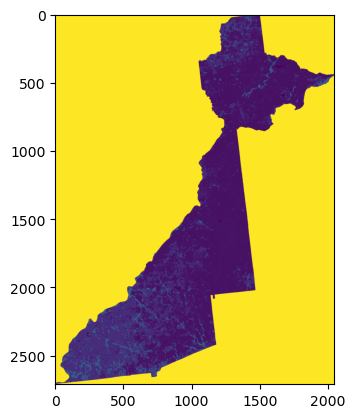

In [21]:
plt.imshow(nlcd_2023_array[0,:,:])

Notice that we specified this plotting by making our array 2D. This gives us more flexibility about how we want to create our plots. You can do something like this:

> This definitely looks more scary than it actually is. Essentially we are:
> 1. constructing a full color spectrum with all the colors we want
> 2. If values are outside of this range, we set the color tot white
> 3. we set the boudnaries for each of these colors so we know which color to assign to what value
> 4. we create legend labels for our legend
>
> This process is only really needed if we want to have a color map for specific values outside of a specific named `matplotlib` named color map.

In [22]:
# Define the colors you want
cmap = matplotlib.colors.ListedColormap(['royalblue', #11
                                        'white', #12
                                        'beige', #21
                                        'salmon', #22
                                        'red', #23
                                        'darkred', #24
                                        'grey', #31
                                        'yellowgreen', #41
                                        'darkgreen', #42
                                        'lightgreen', # 43
                                        'darkgoldenrod', #51
                                        'tan', # 52
                                        'wheat', # 71
                                        'darkkhaki', #72
                                        'darkseagreen', #73
                                         'mediumseagreen', #74
                                         'gold', #81
                                         'chocolate', #82
                                         'lightsteelblue', #90
                                         'steelblue', #95
                                        ])
cmap.set_under('#FFFFFF')
cmap.set_over('#FFFFFF')
# Define a normalization from values -> colors
norm = matplotlib.colors.BoundaryNorm([10.5,
                                       11.5,
                                       12.5,
                                       21.5,
                                       22.5,
                                       23.5,
                                       24.5,
                                       31.5,
                                       41.5, 
                                       42.5,
                                       43.5,
                                       51.5,
                                       52.5,
                                       71.5,
                                       72.5,
                                       73.5,
                                       74.5,
                                       81.5,
                                       82.5,
                                       90.5,
                                       95.5,
                                      ],20)


legend_labels = { 'royalblue':'Open Water', 
                  'white':'Perennial Ice/Snow',
                  'beige':'Developed, Open Space',
                  'salmon':'Developed, Low Intensity',
                  'red':'Developed, Medium Intensity',
                  'darkred':'Developed High Intensity',
                  'grey':'Barren Land (Rock/Sand/Clay)',
                  'yellowgreen':'Deciduous Forest',
                  'darkgreen':'Evergreen Forest',
                  'lightgreen':'Mixed Forest',
                  'darkgoldenrod':'Dwarf Scrub',
                  'tan':'Shrub/Scrub',
                  'wheat':'Grassland/Herbaceous',
                  'darkkhaki':'Sedge/Herbaceous',
                  'darkseagreen':'Lichens',
                  'mediumseagreen':'Moss',
                  'gold':'Pasture/Hay',
                  'chocolate':'Cultivated Crops',
                  'lightsteelblue':'Woody Wetlands',
                  'steelblue':'Emergent Herbaceous Wetlands'}

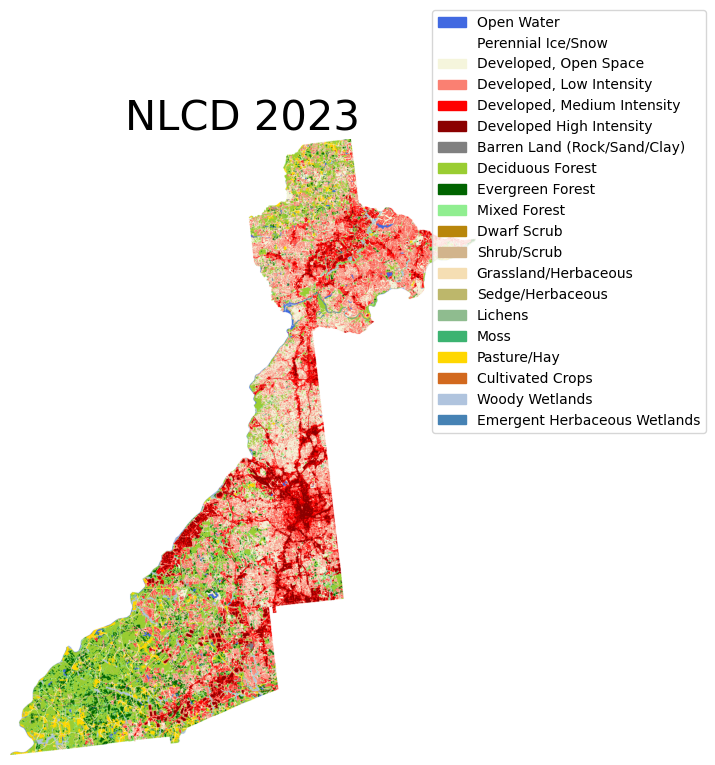

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
plt_nlcd = ax.imshow(nlcd_2023_array[0,:,:], cmap=cmap, norm=norm)
ax.set_title('NLCD 2023', fontsize=30)

# Remove axes
ax.set_frame_on(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks([])
ax.set_yticks([])

# Add color bar
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

fig.legend(handles=patches, facecolor="white",bbox_to_anchor=(1.1, 1.05))

## Other resources
We really only grazed the surface here. We've linked a couple of resources that dive into raster data.

- [EarthLab](https://www.earthdatascience.org)
- [Software Carpentry](https://carpentries-incubator.github.io/geospatial-python/aio/index.html)
- [Intro to Python GIS](https://automating-gis-processes.github.io/CSC/index.html)